<h1 style="text-align: center;">Amazon Fine Food Reviews</h1>

<h1 style="text-align: center;">Predicting Review Scores from Text</h1>

# Import Necessary Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Step 1: Data Collection

## 1.1 Download the dataset from Kaggle (Amazon Fine Food Reviews)

In [2]:
path = "C:/Users/dell/Documents/ML Training/Amazon Fine Food Review Analysis/archive (9)/Reviews.csv"

## 1.2 Load the dataset into a Jupyter notebook

In [3]:
df = pd.read_csv(path)

## 1.3 Inspect the dataset structure and features

### 1.3(a) Displaying first few rows

In [4]:
df = df.head(5000)
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

### 1.3(b) Displaying information of all columns in dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5000 non-null   int64 
 1   ProductId               5000 non-null   object
 2   UserId                  5000 non-null   object
 3   ProfileName             5000 non-null   object
 4   HelpfulnessNumerator    5000 non-null   int64 
 5   HelpfulnessDenominator  5000 non-null   int64 
 6   Score                   5000 non-null   int64 
 7   Time                    5000 non-null   int64 
 8   Summary                 5000 non-null   object
 9   Text                    5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


# Step 2: Data Preprocessing

## 2.1 Handling Missing Values

In [6]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We can see there are some missing values. We will drop null values.

In [7]:
df1 = df.dropna()
df1.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We can see there now thee ae no missing values.

## 2.2 Data Cleaning

### 2.2(a) Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [8]:
#Sorting data according to ProductId in ascending order
df1.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# droping duplicates
df2 = df1.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
df2.shape

(4985, 10)

### 2.2(b) Filtering out those roles where HelpfulnessNumerator is greater than HelpfulnessDenominator

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
# HelpfulnessNumerator should always less than HelpfulnessDenominator
final = df2[df2['HelpfulnessNumerator'] <= df2['HelpfulnessDenominator']]
final.shape

(4985, 10)

### 2.2(c) Filtering only positive and negative reviews(1,2 as negative and 4,5 as positive) i.e.not taking into consideration those reviews with Score=3

In [10]:
final = final[final['Score'] != 3]

# Coverting Score values in final into categorical data either 1(Positive) or 0(Negative)
def partition(x):
    if x < 3:
        return 0
    return 1

score_update = final['Score']
t = score_update.map(partition)
final['Score'] = t

final.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   
3                     3                       3      0  1307923200   
4                     0                       0      1  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [11]:
final['Score'].value_counts()

1    3838
0     754
Name: Score, dtype: int64

### 2.2(d) Remove HTML tags, punctuation, and special characters from review texts

In [12]:
sent_35 = final['Text'].values[35]
print(sent_35)
print("="*50)
sent_11 = final['Text'].values[11]
print(sent_11)

For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store!  I love McCann's instant oatmeal - all flavors!!!<br /><br />Thanks,<br />Abby
One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week.


As we can see there are html tags, punctuation and special characters in above text.

In [13]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(sent_35, 'lxml')
sent_35 = soup.get_text()
res = re.sub(r'[^\w\s]', '', sent_35)
sent_35 = res
print(sent_35)
print("="*50)
soup = BeautifulSoup(sent_11, 'lxml')
sent_11 = soup.get_text()
res = re.sub(r'[^\w\s]', '', sent_11)
sent_11 = res
print(sent_11)

For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store  I love McCanns instant oatmeal  all flavorsThanksAbby
One of my boys needed to lose some weight and the other didnt  I put this food on the floor for the chubby guy and the proteinrich no byproduct food up higher where only my skinny boy can jump  The higher food sits going stale  They both really go for this food  And my chubby boy has been losing about an ounce a week


There might be a chance that the text may contain urls. So we have to remove it to.

In [14]:
url_text = re.sub(r'http\S+', '', sent_35)
sent_35 = url_text
print(sent_35)

For those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store  I love McCanns instant oatmeal  all flavorsThanksAbby


Removing apostrophes

In [15]:
sent_11 = final['Text'].values[11]
phrase = sent_11
phrase = re.sub(r"n\'t", " not", phrase)
phrase = re.sub(r"\'re", " are", phrase)
phrase = re.sub(r"\'s", " is", phrase)
phrase = re.sub(r"\'d", " would", phrase)
phrase = re.sub(r"\'ll", " will", phrase)
phrase = re.sub(r"\'t", " not", phrase)
phrase = re.sub(r"\'ve", " have", phrase)
phrase = re.sub(r"\'m", " am", phrase)
sent_11 = phrase
print(sent_11)

One of my boys needed to lose some weight and the other did not.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week.


Removing spacial character

In [16]:
sent_11 = re.sub('[^A-Za-z0-9]+', ' ', sent_11)
print(sent_11)

One of my boys needed to lose some weight and the other did not I put this food on the floor for the chubby guy and the protein rich no by product food up higher where only my skinny boy can jump The higher food sits going stale They both really go for this food And my chubby boy has been losing about an ounce a week 


## 2.3 Text Normalization

### 2.3(a) Converting the text to lowercase.

In [17]:
sent_35 = sent_35.lower()
print(sent_35)
print("="*50)
sent_11 = sent_11.lower()
print(sent_11)

for those of us with celiac disease this product is a lifesaver and what could be better than getting it at almost half the price of the grocery or health food store  i love mccanns instant oatmeal  all flavorsthanksabby
one of my boys needed to lose some weight and the other did not i put this food on the floor for the chubby guy and the protein rich no by product food up higher where only my skinny boy can jump the higher food sits going stale they both really go for this food and my chubby boy has been losing about an ounce a week 


In [18]:
# To see all the stopwords see the below code cell.
stop = set(stopwords.words('english'))
print(stop)

{'by', 'under', 'won', 'him', 'this', 'himself', "weren't", 'any', 'don', 'all', 'll', 'those', 'such', "doesn't", "she's", 'no', 'just', 'my', 'how', 'myself', 'on', 'ain', "you're", 'his', 'before', "isn't", 'ma', 'same', 'didn', 'm', 'needn', 'with', 'too', 'them', 'yourself', 'isn', 'themselves', 'being', 'haven', 'in', 'again', 'mustn', 'had', 'while', 'has', 'off', 'so', 'until', 'through', 'hers', 'if', 'shouldn', 'there', 'into', 'only', 'or', 're', 'mightn', 'it', 'wouldn', "you'd", 'weren', "you've", 'not', 'she', 'whom', 'which', 'at', 't', 'will', 'should', 'their', 'theirs', 'you', 'very', 'out', 'yourselves', 'but', 'from', 'where', 'aren', 'here', 'these', 'further', 'y', 'doing', 'our', 'are', "didn't", 've', 'been', 'for', "haven't", "it's", "shouldn't", 'a', 'each', 'hasn', 'down', 'o', "couldn't", "hasn't", 'can', 'ourselves', "that'll", 'who', "don't", 'herself', "should've", 'yours', 'as', 'her', 'shan', 'once', 'the', 'he', 'up', 's', 'was', 'its', 'other', 'have'

In [19]:
demo_final_X = final["Text"]

In [20]:
demo_final_X

0       I have bought several of the Vitality canned d...
1       Product arrived labeled as Jumbo Salted Peanut...
2       This is a confection that has been around a fe...
3       If you are looking for the secret ingredient i...
4       Great taffy at a great price.  There was a wid...
                              ...                        
4994    If you are on the paleo/caveman/primal/hunter-...
4995    I really wanted to like these.<br /><br />Firs...
4996    I was not impressed with these cookies when I ...
4998    These taste very good, but aren't like the BES...
4999    I love these cookies. I am on the paleo diet r...
Name: Text, Length: 4592, dtype: object

In [21]:
from tqdm import tqdm
temp = []
snow = nltk.stem.SnowballStemmer('english')
for sentence in tqdm(demo_final_X):
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]
    temp.append(words)

demo_final_X = temp
demo_final_X

100%|██████████████████████████████████████████████████████████████████████████████| 4592/4592 [01:13<00:00, 62.08it/s]


[['i',
  'bought',
  'sever',
  'vital',
  'can',
  'dog',
  'food',
  'product',
  'found',
  'good',
  'quality.',
  'the',
  'product',
  'look',
  'like',
  'stew',
  'process',
  'meat',
  'smell',
  'better.',
  'my',
  'labrador',
  'finicki',
  'appreci',
  'product',
  'better',
  'most.'],
 ['product',
  'arriv',
  'label',
  'jumbo',
  'salt',
  'peanuts...th',
  'peanut',
  'actual',
  'small',
  'size',
  'unsalted.',
  'not',
  'sure',
  'error',
  'vendor',
  'intend',
  'repres',
  'product',
  '"jumbo".'],
 ['this',
  'confect',
  'around',
  'centuries.',
  'it',
  'light,',
  'pillowi',
  'citrus',
  'gelatin',
  'nut',
  '-',
  'case',
  'filberts.',
  'and',
  'cut',
  'tini',
  'squar',
  'liber',
  'coat',
  'powder',
  'sugar.',
  'and',
  'tini',
  'mouth',
  'heaven.',
  'not',
  'chewy,',
  'flavorful.',
  'i',
  'high',
  'recommend',
  'yummi',
  'treat.',
  'if',
  'familiar',
  'stori',
  'c.s.',
  'lewi',
  '"the',
  'lion,',
  'the',
  'witch,',
  'the'

### We are going to make a preprocess function

In [22]:
from tqdm import tqdm
temp = []
snow = nltk.stem.SnowballStemmer('english')

def prepreprocess(data):
    for sentence in tqdm(data):
        sentence = sentence.lower() # Converting to lowercase
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, '', sentence) # Removing HTML tags
        sentence = re.sub(r'[?|!|\'|"|#]','', sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]','', sentence)# Removing Punctuations
        sentence = re.sub(r'http\S+','', sentence)# Removing URL
        sentence = re.sub(r'[0-9]+', '', sentence)# Removing Digits
    
        words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]
        listToStr = ' '.join(map(str, words))
        temp.append(listToStr.strip())

In [23]:
final_X = final["Text"]
final_Y = final["Score"]

In [24]:
final_X

0       I have bought several of the Vitality canned d...
1       Product arrived labeled as Jumbo Salted Peanut...
2       This is a confection that has been around a fe...
3       If you are looking for the secret ingredient i...
4       Great taffy at a great price.  There was a wid...
                              ...                        
4994    If you are on the paleo/caveman/primal/hunter-...
4995    I really wanted to like these.<br /><br />Firs...
4996    I was not impressed with these cookies when I ...
4998    These taste very good, but aren't like the BES...
4999    I love these cookies. I am on the paleo diet r...
Name: Text, Length: 4592, dtype: object

In [25]:
final_Y

0       1
1       0
2       1
3       0
4       1
       ..
4994    1
4995    0
4996    0
4998    1
4999    1
Name: Score, Length: 4592, dtype: int64

In [26]:
prepreprocess(final_X)
final_X = temp
final_X

100%|██████████████████████████████████████████████████████████████████████████████| 4592/4592 [01:12<00:00, 63.69it/s]


['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better',
 'product arriv label jumbo salt peanutsth peanut actual small size unsalt sure error vendor intend repres product jumbo',
 'confect around centuri light pillowi citrus gelatin nut - case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori cs lewi lion witch wardrob - treat seduc edmund sell brother sister witch',
 'look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin',
 'great taffi great price wide assort yummi taffi deliveri quick taffi lover deal',
 'got wild hair taffi order five pound bag taffi enjoy mani flavors: watermelon root beer melon peppermint grape etc complaint bit much redblack licorice-flavor piec particular favorit kid husband last two week would recommend brand taffi -- delight treat',
 's

# Step 3: Exploratory Data Analysis (EDA)

## 3.1 Data Visualization

### 3.1(a) Visualize the distribution of review scores

In [27]:
final_Y.value_counts()

1    3838
0     754
Name: Score, dtype: int64

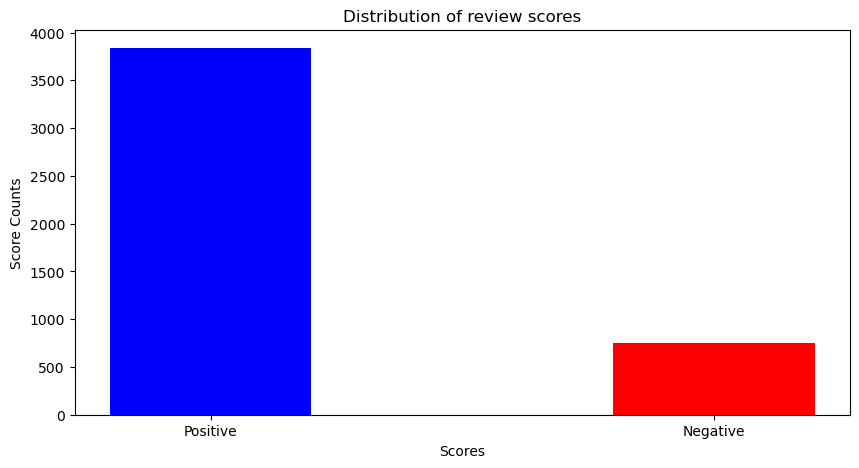

In [28]:
plot_data = data = {'Positive':3838, 'Negative':754}

Score = list(data.keys())
Score_count = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(Score, Score_count, color = ['blue', 'red'], width = 0.4)

plt.xlabel("Scores")
plt.ylabel("Score Counts")
plt.title("Distribution of review scores")
plt.show()

### 3.1(b) Explore the most frequent words in the reviews

In [29]:
import string

f = final['Text']

from collections import Counter
def tokenize_text(f):
    tokens = nltk.word_tokenize(f)
    return tokens

stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)

def count_word_frequencies(f):
    word_freq = Counter()
    for review in f:
        review = review.lower() # Converting to lowercase
        cleanr = re.compile('<.*?>')
        review = re.sub(cleanr, ' ', review) # Removing HTML tags
        review = re.sub(r'[?|!|\'|"|#]',r'', review)
        review = re.sub(r'[.|,|)|(|\|/]',r' ', review)# Removing Punctuations
        review = re.sub(r'http\S+',r'', review)# Removing URL
        review = re.sub('[^A-Za-z0-9]+', r' ', review)# Removing Digits
        tokens = tokenize_text(review)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        
        word_freq.update(filtered_tokens)
    return word_freq

def display_top_words(word_freq, top_n=30):
    top_words = word_freq.most_common(top_n)
    for word, freq in top_words:
        print(f'{word}: {freq}')


In [30]:
word_freq = count_word_frequencies(f)
display_top_words(word_freq)

like: 1829
good: 1631
great: 1429
taste: 1272
one: 1211
product: 1194
flavor: 1098
chips: 1010
love: 997
coffee: 987
food: 925
would: 863
tea: 860
really: 777
get: 750
dont: 696
best: 696
much: 692
use: 659
also: 652
amazon: 641
time: 639
tried: 637
buy: 631
little: 628
make: 616
find: 606
price: 594
bag: 587
better: 578


In [31]:
def top_words(word_freq, top_n=30):
    top = word_freq.most_common(top_n)
    return top
top = top_words(word_freq)
print(top)

[('like', 1829), ('good', 1631), ('great', 1429), ('taste', 1272), ('one', 1211), ('product', 1194), ('flavor', 1098), ('chips', 1010), ('love', 997), ('coffee', 987), ('food', 925), ('would', 863), ('tea', 860), ('really', 777), ('get', 750), ('dont', 696), ('best', 696), ('much', 692), ('use', 659), ('also', 652), ('amazon', 641), ('time', 639), ('tried', 637), ('buy', 631), ('little', 628), ('make', 616), ('find', 606), ('price', 594), ('bag', 587), ('better', 578)]


In [32]:
str = ""
i = 0
for word in top:
    str = str + top[i][0] + " "
    i = i + 1
str = str.strip()
print(str)

like good great taste one product flavor chips love coffee food would tea really get dont best much use also amazon time tried buy little make find price bag better


In [33]:
str = " "
text = str.join(final['Text'])
text

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch. If you are looking for the secret

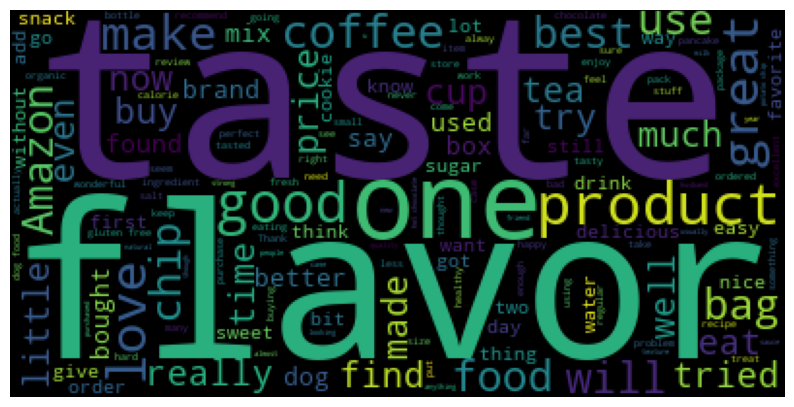

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color ='black')
html_pattern = re.compile('<.*?>')
clean_text = re.sub(html_pattern, '', text)
wc.generate(clean_text)
plt.figure(figsize = (10, 8),facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.show()

## 3.2 Sentiment Analysis

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [36]:
f = final['Text']
temp = []
for review in f:
        review = review.lower() # Converting to lowercase
        cleanr = re.compile('<.*?>')
        review = re.sub(cleanr, ' ', review) # Removing HTML tags
        review = re.sub(r'[?|!|\'|"|#]','', review)
        review = re.sub(r'[.|,|)|(|\|/]',' ', review)# Removing Punctuations
        review = re.sub(r'http\S+','', review)# Removing URL
        review = re.sub(r'\d', '' , review)
        temp.append(review)  
f = temp
f
#f = pd.DataFrame(temp[1:3])



['i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most ',
 'product arrived labeled as jumbo salted peanuts   the peanuts were actually small sized unsalted  not sure if this was an error or if the vendor intended to represent the product as jumbo ',
 'this is a confection that has been around a few centuries   it is a light  pillowy citrus gelatin with nuts - in this case filberts  and it is cut into tiny squares and then liberally coated with powdered sugar   and it is a tiny mouthful of heaven   not too chewy  and very flavorful   i highly recommend this yummy treat   if you are familiar with the story of c s  lewis the lion  the witch  and the wardrobe - this is the treat that seduces edmund into selling out his brother and sisters to the witch ',
 'if you are looking for the

In [37]:
sid = SentimentIntensityAnalyzer()
def analyse_sentiment(f):
    positive = 0 
    negative = 0
    for text in f:
        # Polarity scores: a dictionary with pos, neu, neg, and compound scores
        sentiment_scores = sid.polarity_scores(text)
        if sentiment_scores['compound'] >= 0.05:
           positive = positive + sentiment_scores['compound']
        elif sentiment_scores['compound'] <= -0.05:
           negative = negative - sentiment_scores['compound']
    return positive, negative

print(analyse_sentiment(f))

(3235.3908999999976, 228.94859999999997)


Looking the above scores we can say majority of reviews are positive.

# Step 4: Feature Engineering

## 4.1 Text Vectorization

### 4.1(a) TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(final_X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(final_X)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abil', 'abl', 'abl find', 'abl get', 'absolut', 'absolut best', 'absolut delici', 'absolut love', 'absorb', 'accept']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4592, 2708)
the number of unique words including both unigrams and bigrams  2708


### 4.1(b) Bag Of Words

In [39]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(final_X)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(final_X)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['_effect_', 'aa', 'aahhh', 'aback', 'abandon', 'abat', 'abdomin', 'abid', 'abil', 'abl']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (4592, 11816)
the number of unique words  11816


## 4.2 Additional Features

In [40]:
# Converting to  dataframe
final_X = pd.DataFrame(final_X)
# renaming column
final_X = final_X.rename(columns={0: 'Reviews'})
final_X

Reviews
0     bought sever vital can dog food product found ...
1     product arriv label jumbo salt peanutsth peanu...
2     confect around centuri light pillowi citrus ge...
3     look secret ingredi robitussin believ found go...
4     great taffi great price wide assort yummi taff...
...                                                 ...
4587  paleocavemanprimalhunter-gather diet ador cook...
4588  realli want like thesefirst cooki size half do...
4589  impress cooki tri first came compani one flavo...
4590  tast good arent like best thing ever either or...
4591  love cooki paleo diet right cooki look forward...

[4592 rows x 1 columns]

### 4.2(a) Adding column of Review Length

In [41]:
def calculate_review_length(review):
    return len(review)

final_X['Review_Length'] = final_X['Reviews'].apply(calculate_review_length)
final_X

Reviews  Review_Length
0     bought sever vital can dog food product found ...            147
1     product arriv label jumbo salt peanutsth peanu...            118
2     confect around centuri light pillowi citrus ge...            256
3     look secret ingredi robitussin believ found go...            114
4     great taffi great price wide assort yummi taff...             79
...                                                 ...            ...
4587  paleocavemanprimalhunter-gather diet ador cook...            168
4588  realli want like thesefirst cooki size half do...            278
4589  impress cooki tri first came compani one flavo...            387
4590  tast good arent like best thing ever either or...            424
4591  love cooki paleo diet right cooki look forward...            360

[4592 rows x 2 columns]

### 4.2(b) Adding column of Review Word Count

In [42]:
def calculate_word_count(review):
    words = review.split()  # Split the review into words
    return len(words)

final_X['Word_Count'] = final_X['Reviews'].apply(calculate_word_count)
final_X

Reviews  Review_Length  \
0     bought sever vital can dog food product found ...            147   
1     product arriv label jumbo salt peanutsth peanu...            118   
2     confect around centuri light pillowi citrus ge...            256   
3     look secret ingredi robitussin believ found go...            114   
4     great taffi great price wide assort yummi taff...             79   
...                                                 ...            ...   
4587  paleocavemanprimalhunter-gather diet ador cook...            168   
4588  realli want like thesefirst cooki size half do...            278   
4589  impress cooki tri first came compani one flavo...            387   
4590  tast good arent like best thing ever either or...            424   
4591  love cooki paleo diet right cooki look forward...            360   

      Word_Count  
0             23  
1             18  
2             42  
3             18  
4             13  
...          ...  
4587          23  
4588          46  
4589          64  
4590          66  
4591          65  

[4592 rows x 3 columns]

In [43]:
final_Y

0       1
1       0
2       1
3       0
4       1
       ..
4994    1
4995    0
4996    0
4998    1
4999    1
Name: Score, Length: 4592, dtype: int64

In [44]:
final_Y.reset_index(drop=True)

0       1
1       0
2       1
3       0
4       1
       ..
4587    1
4588    0
4589    0
4590    1
4591    1
Name: Score, Length: 4592, dtype: int64

# Step 5: Model Building

First we will reset the index as the indexes are not in proper sequence and when we will merge it with another dataframe the sequece of index of both dataframe will not match as a result we will have null values in our data.

In [45]:
final = final.reset_index(drop=True)
final

Id   ProductId          UserId                      ProfileName  \
0        1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1        2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2        3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3        4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4        5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...    ...         ...             ...                              ...   
4587  4995  B00653KJ5M   AZLTR11CYKN5V                      RyanTheLion   
4588  4996  B00653KJ5M   AGE64SY3HP9RV                               CZ   
4589  4997  B00653KJ5M   A1MPEPNJ2NKWM             Rachel Albert Matesz   
4590  4999  B00653KJ5M  A3POAWC2JPQQQP                               me   
4591  5000  B00653KJ5M  A122CSYJ3YSKI0                          Shaimun   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                        1                       1      1  1303862400   
1                        0                       0      0  1346976000   
2                        1                       1      1  1219017600   
3                        3                       3      0  1307923200   
4                        0                       0      1  1350777600   
...                    ...                     ...    ...         ...   
4587                     4                       4      1  1322784000   
4588                     1                       1      0  1341273600   
4589                     1                       1      0  1341100800   
4590                     0                       0      1  1342137600   
4591                     0                       0      1  1337990400   

                                                Summary  \
0                                 Good Quality Dog Food   
1                                     Not as Advertised   
2                                 "Delight" says it all   
3                                        Cough Medicine   
4                                           Great taffy   
...                                                 ...   
4587                                           AMAZING!   
4588                 The cavemen must have been wealthy   
4589  These cookies need work; you can make your own...   
4590  they are good (except for the "rainforest" fla...   
4591                               Great Healthy Snack!   

                                                   Text  
0     I have bought several of the Vitality canned d...  
1     Product arrived labeled as Jumbo Salted Peanut...  
2     This is a confection that has been around a fe...  
3     If you are looking for the secret ingredient i...  
4     Great taffy at a great price.  There was a wid...  
...                                                 ...  
4587  If you are on the paleo/caveman/primal/hunter-...  
4588  I really wanted to like these.<br /><br />Firs...  
4589  I was not impressed with these cookies when I ...  
4590  These taste very good, but aren't like the BES...  
4591  I love these cookies. I am on the paleo diet r...  

[4592 rows x 10 columns]

In [46]:
final['Preprocessed'] = final_X['Reviews']
final['Review_Length'] = final_X['Review_Length']
final['Word_Count'] = final_X['Word_Count']
final

Id   ProductId          UserId                      ProfileName  \
0        1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1        2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2        3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3        4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4        5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...    ...         ...             ...                              ...   
4587  4995  B00653KJ5M   AZLTR11CYKN5V                      RyanTheLion   
4588  4996  B00653KJ5M   AGE64SY3HP9RV                               CZ   
4589  4997  B00653KJ5M   A1MPEPNJ2NKWM             Rachel Albert Matesz   
4590  4999  B00653KJ5M  A3POAWC2JPQQQP                               me   
4591  5000  B00653KJ5M  A122CSYJ3YSKI0                          Shaimun   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                        1                       1      1  1303862400   
1                        0                       0      0  1346976000   
2                        1                       1      1  1219017600   
3                        3                       3      0  1307923200   
4                        0                       0      1  1350777600   
...                    ...                     ...    ...         ...   
4587                     4                       4      1  1322784000   
4588                     1                       1      0  1341273600   
4589                     1                       1      0  1341100800   
4590                     0                       0      1  1342137600   
4591                     0                       0      1  1337990400   

                                                Summary  \
0                                 Good Quality Dog Food   
1                                     Not as Advertised   
2                                 "Delight" says it all   
3                                        Cough Medicine   
4                                           Great taffy   
...                                                 ...   
4587                                           AMAZING!   
4588                 The cavemen must have been wealthy   
4589  These cookies need work; you can make your own...   
4590  they are good (except for the "rainforest" fla...   
4591                               Great Healthy Snack!   

                                                   Text  \
0     I have bought several of the Vitality canned d...   
1     Product arrived labeled as Jumbo Salted Peanut...   
2     This is a confection that has been around a fe...   
3     If you are looking for the secret ingredient i...   
4     Great taffy at a great price.  There was a wid...   
...                                                 ...   
4587  If you are on the paleo/caveman/primal/hunter-...   
4588  I really wanted to like these.<br /><br />Firs...   
4589  I was not impressed with these cookies when I ...   
4590  These taste very good, but aren't like the BES...   
4591  I love these cookies. I am on the paleo diet r...   

                                           Preprocessed  Review_Length  \
0     bought sever vital can dog food product found ...            147   
1     product arriv label jumbo salt peanutsth peanu...            118   
2     confect around centuri light pillowi citrus ge...            256   
3     look secret ingredi robitussin believ found go...            114   
4     great taffi great price wide assort yummi taff...             79   
...                                                 ...            ...   
4587  paleocavemanprimalhunter-gather diet ador cook...            168   
4588  realli want like thesefirst cooki size half do...            278   
4589  impress cooki tri first came compani one flavo...            387   
4590  tast good arent like best thing ever either or...            424  

In [47]:
final = final.drop(['Id' , 'ProductId' , 'UserId' , 'ProfileName' , 'Time' , 'Summary' , 'Text'] , axis=1)
final

HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0                        1                       1      1   
1                        0                       0      0   
2                        1                       1      1   
3                        3                       3      0   
4                        0                       0      1   
...                    ...                     ...    ...   
4587                     4                       4      1   
4588                     1                       1      0   
4589                     1                       1      0   
4590                     0                       0      1   
4591                     0                       0      1   

                                           Preprocessed  Review_Length  \
0     bought sever vital can dog food product found ...            147   
1     product arriv label jumbo salt peanutsth peanu...            118   
2     confect around centuri light pillowi citrus ge...            256   
3     look secret ingredi robitussin believ found go...            114   
4     great taffi great price wide assort yummi taff...             79   
...                                                 ...            ...   
4587  paleocavemanprimalhunter-gather diet ador cook...            168   
4588  realli want like thesefirst cooki size half do...            278   
4589  impress cooki tri first came compani one flavo...            387   
4590  tast good arent like best thing ever either or...            424   
4591  love cooki paleo diet right cooki look forward...            360   

      Word_Count  
0             23  
1             18  
2             42  
3             18  
4             13  
...          ...  
4587          23  
4588          46  
4589          64  
4590          66  
4591          65  

[4592 rows x 6 columns]

In [48]:
y = final['Score'].values
X = final.drop(columns=['Score'])
print(X.shape)
print(y.shape)

(4592, 5)
(4592,)


In [49]:
X.head()

HelpfulnessNumerator  HelpfulnessDenominator  \
0                     1                       1   
1                     0                       0   
2                     1                       1   
3                     3                       3   
4                     0                       0   

                                        Preprocessed  Review_Length  \
0  bought sever vital can dog food product found ...            147   
1  product arriv label jumbo salt peanutsth peanu...            118   
2  confect around centuri light pillowi citrus ge...            256   
3  look secret ingredi robitussin believ found go...            114   
4  great taffi great price wide assort yummi taff...             79   

   Word_Count  
0          23  
1          18  
2          42  
3          18  
4          13

In [50]:
y

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

## 5.1 Train-Test Split

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

from scipy import sparse

In [52]:
print(len(X_train))
print(len(y_train))

3214
3214


In [53]:
print(len(X_test))
print(len(y_test))

1378
1378


#### Text Vectorization on training and testing dataset for TF-IDF

##### Training Dataset

In [54]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train['Preprocessed'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train['Preprocessed'])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abl', 'abl find', 'absolut', 'absolut delici', 'absolut love', 'accord', 'acid', 'across', 'activ', 'actual']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3214, 1978)
the number of unique words including both unigrams and bigrams  1978


In [55]:
num_features = X_train[['HelpfulnessNumerator' , 'HelpfulnessDenominator' , 'Review_Length' , 'Word_Count']].values
train_tf_idf = sparse.hstack((num_features , final_tf_idf))
train_tf_idf

<3214x1982 sparse matrix of type '<class 'numpy.float64'>'
	with 103270 stored elements in COOrdinate format>

##### Testing Dataset

In [56]:
final_tf_idf_test = tf_idf_vect.transform(X_test['Preprocessed'])
num_features_test = X_test[['HelpfulnessNumerator' , 'HelpfulnessDenominator' , 'Review_Length' , 'Word_Count']].values
test_tf_idf = sparse.hstack((num_features_test , final_tf_idf_test))
test_tf_idf

<1378x1982 sparse matrix of type '<class 'numpy.float64'>'
	with 43127 stored elements in COOrdinate format>

#### Text Vectorization on training and testing dataset for Bag of Words

##### Training Dataset

In [57]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['Preprocessed'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train['Preprocessed'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['_effect_', 'aa', 'aahhh', 'abandon', 'abat', 'abid', 'abil', 'abl', 'abor', 'aboulut']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (3214, 9641)
the number of unique words  9641


In [58]:
num_features = X_train[['HelpfulnessNumerator' , 'HelpfulnessDenominator' , 'Review_Length' , 'Word_Count']].values
train_bag_of_words = sparse.hstack((num_features , final_counts))
train_bag_of_words

<3214x9645 sparse matrix of type '<class 'numpy.int64'>'
	with 109807 stored elements in COOrdinate format>

##### Testing Dataset

In [59]:
final_bag_of_words_test = count_vect.transform(X_test['Preprocessed'])
num_features_test = X_test[['HelpfulnessNumerator' , 'HelpfulnessDenominator' , 'Review_Length' , 'Word_Count']].values
test_bag_of_words = sparse.hstack((num_features_test , final_bag_of_words_test))
test_bag_of_words

<1378x9645 sparse matrix of type '<class 'numpy.int64'>'
	with 43974 stored elements in COOrdinate format>

## 5.2 Model Selection and Model Evaluation

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

## 5.2(a) Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

### 5.2(a1) Logistic Regression and TF-IDF

In [62]:
lr = LogisticRegression(random_state=0)
lr.fit(train_tf_idf, y_train)

LogisticRegression(random_state=0)

In [63]:
y_pred = lr.predict(test_tf_idf)
y_pred

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 88.38896952104498
Precision Score (in %): 88.73348873348873
Recall Score (in %): 98.70354364736387
f1 Score (in %): [48.71794872 93.45335516]
Confusion Matrix


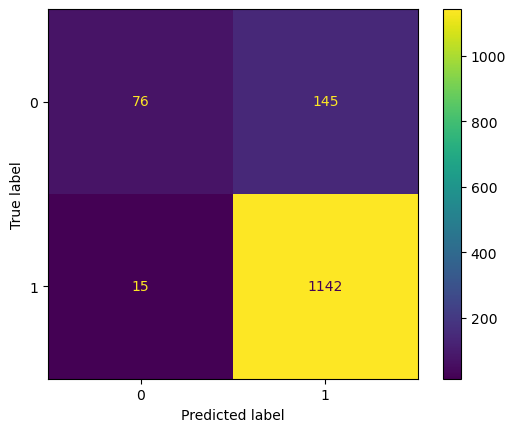

In [64]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

### 5.2(a2) Logistic Regression and Bag of Words

In [65]:
lr = LogisticRegression(random_state=0)
lr.fit(train_bag_of_words, y_train)

LogisticRegression(random_state=0)

In [66]:
y_pred = lr.predict(test_bag_of_words)
y_pred

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 90.20319303338171
Precision Score (in %): 92.30132450331125
Recall Score (in %): 96.36992221261885
f1 Score (in %): [65.47314578 94.29175476]
Confusion Matrix


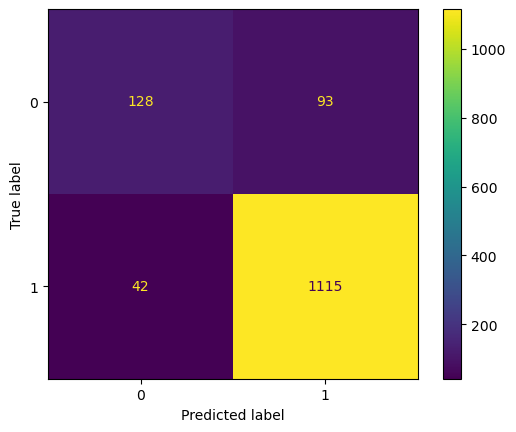

In [67]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

## 5.2(b) Naive Bayes

In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

### 5.2(b1) Naive Bayes and TF-IDF

In [69]:
gnb = GaussianNB()
gnb.fit(train_tf_idf.todense(), y_train)

GaussianNB()

In [70]:
y_pred = gnb.predict(test_tf_idf.todense())
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 77.72133526850507
Precision Score (in %): 93.27902240325867
Recall Score (in %): 79.17026793431288
f1 Score (in %): [50.24311183 85.64749883]
Confusion Matrix


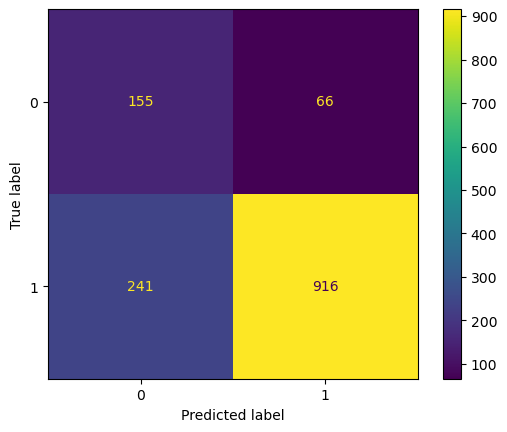

In [71]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

### 5.2(b2) Naive Bayes and Bag Of Words

In [72]:
gnb = GaussianNB()
gnb.fit(train_bag_of_words.todense(), y_train)

GaussianNB()

In [73]:
y_pred = gnb.predict(test_bag_of_words.todense())
y_pred

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 63.062409288824384
Precision Score (in %): 86.32286995515696
Recall Score (in %): 66.5514261019879
f1 Score (in %): [28.00565771 75.15861396]
Confusion Matrix


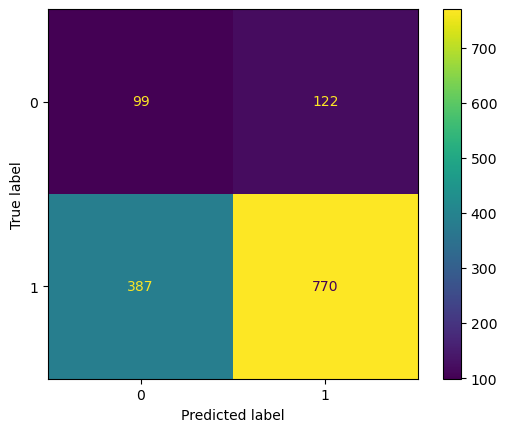

In [74]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

## 5.2(c) Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

### 5.2(c1) Random Forest and TF-IDF

In [76]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(train_tf_idf.todense(), y_train)

RandomForestClassifier()

In [77]:
y_pred = rf.predict(test_tf_idf.todense())
y_pred

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 86.71988388969521
Precision Score (in %): 86.67168674698796
Recall Score (in %): 99.48141745894556
f1 Score (in %): [32.47232472 92.63581489]
Confusion Matrix


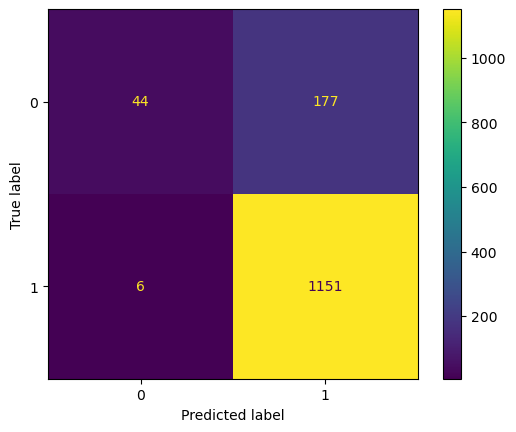

In [78]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

### 5.2(c2) Random Forest and Bag Of Words

In [79]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(train_bag_of_words.todense(), y_train)

RandomForestClassifier()

In [80]:
y_pred = rf.predict(test_bag_of_words.todense())
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 85.84905660377359
Precision Score (in %): 85.73551263001485
Recall Score (in %): 99.74070872947277
f1 Score (in %): [22.92490119 92.20934878]
Confusion Matrix


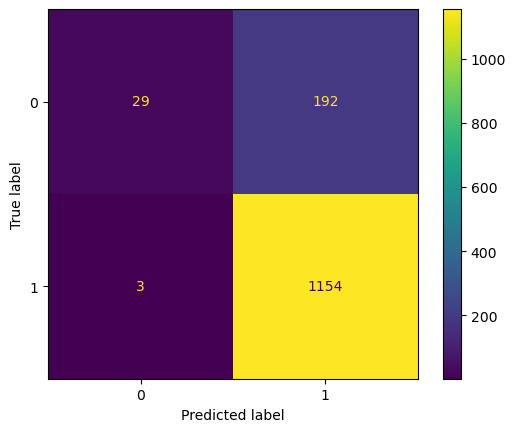

In [81]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

 ## 5.2(d) K - Nearest Neighbour

In [82]:
from sklearn.neighbors import KNeighborsClassifier 

### 5.2(d1) K - Nearest Neighbour and TF-IDF

In [83]:
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(train_tf_idf.todense(), y_train) 

KNeighborsClassifier(n_neighbors=9)

In [84]:
y_pred = knn.predict(test_tf_idf.todense())
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 84.03483309143687
Precision Score (in %): 84.37270726338959
Recall Score (in %): 99.39498703543647
f1 Score (in %): [ 6.77966102 91.26984127]
Confusion Matrix


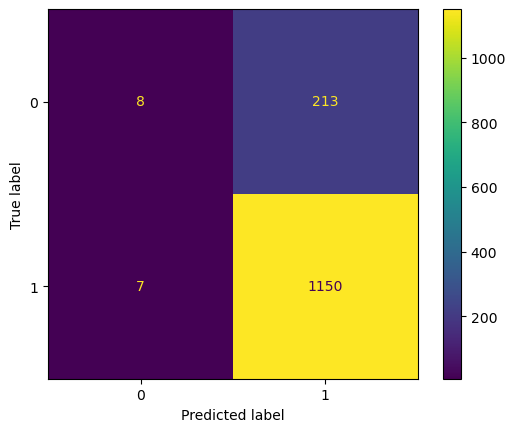

In [85]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

### 5.2(d2) K - Nearest Neighbour and Bag Of Words

In [86]:
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(train_bag_of_words.todense(), y_train) 

KNeighborsClassifier(n_neighbors=9)

In [87]:
y_pred = knn.predict(test_bag_of_words.todense())
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Model Evaluation

Accuracy Score (in %): 84.1799709724238
Precision Score (in %): 84.49669360764143
Recall Score (in %): 99.39498703543647
f1 Score (in %): [ 8.40336134 91.34233519]
Confusion Matrix


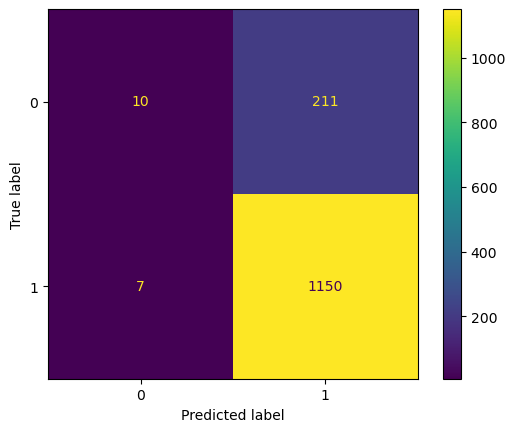

In [88]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

precision = precision_score(y_test, y_pred)
print("Precision Score (in %):", precision*100)

recall = recall_score(y_test, y_pred)
print("Recall Score (in %):", recall*100)

f1 = f1_score(y_test, y_pred, average=None)
print("f1 Score (in %):", f1*100)

print("Confusion Matrix")
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

# Step 6: Hyperparameter Tuning

###### Using Randomized Search CV

In [89]:
from sklearn.model_selection import RandomizedSearchCV

## Logistics Regression

In [90]:
param_grid = {
    'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2500,5000]
}

In [91]:
random_search = RandomizedSearchCV(lr, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=0)

### with TF-IDF

In [92]:
random_search.fit(train_tf_idf, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 1000, 2500, 5000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=0, scoring='accuracy')

In [93]:
best_param = random_search.best_params_
best_param

{'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 1000,
 'C': 1.623776739188721}

In [94]:
lr_tf_idf = LogisticRegression(random_state=0, solver='lbfgs', penalty='none', max_iter=1000, C=1.623776739188721)
lr_tf_idf.fit(train_tf_idf, y_train)

y_pred = lr_tf_idf.predict(test_tf_idf)

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 90.27576197387518


### with Bag Of Words

In [95]:
random_search.fit(train_bag_of_words, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 1000, 2500, 5000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=0, scoring='accuracy')

In [96]:
best_param = random_search.best_params_
best_param

{'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 1000,
 'C': 1.623776739188721}

In [97]:
lr_bag_of_words = LogisticRegression(random_state=0, solver='lbfgs', penalty='none', max_iter=1000, C=1.623776739188721)
lr_bag_of_words.fit(train_bag_of_words, y_train)

y_pred = lr_bag_of_words.predict(test_bag_of_words)

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 88.82438316400581


## Naive Bayes

In [98]:
from scipy.stats import uniform
param_dist = {
    'var_smoothing': uniform(1e-9, 1e-7),  # Smoothing parameter for GaussianNB
}

In [99]:
random_search = RandomizedSearchCV(gnb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

### with TF-IDF

In [100]:
random_search.fit(train_tf_idf.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F3B132AA60>},
                   random_state=42, scoring='accuracy')

In [101]:
best_param = random_search.best_params_
best_param

{'var_smoothing': 9.607143064099161e-08}

In [102]:
gnb_tf_idf = GaussianNB(var_smoothing=9.968869366005172e-08)
gnb_tf_idf.fit(train_tf_idf.todense(), y_train)

y_pred = gnb_tf_idf.predict(test_tf_idf.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 79.68069666182875


### with Bag Of Word

In [103]:
random_search.fit(train_bag_of_words.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F3B132AA60>},
                   random_state=42, scoring='accuracy')

In [104]:
best_param = random_search.best_params_
best_param

{'var_smoothing': 9.607143064099161e-08}

In [105]:
gnb_bag_of_words = GaussianNB(var_smoothing=9.607143064099161e-08)
gnb_bag_of_words.fit(train_bag_of_words.todense(), y_train)

y_pred = gnb_bag_of_words.predict(test_bag_of_words.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 85.41364296081278


## Random Forest

In [106]:
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None]
}

In [107]:
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=0)

### with TF-IDF

In [108]:
random_search.fit(train_tf_idf.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B1016F10>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B1016BB0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B13DF490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B135A640>},
                   random_state=0, scoring='accuracy')

In [109]:
best_param = random_search.best_params_
best_param

{'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 12,
 'min_samples_split': 4,
 'n_estimators': 10}

In [110]:
rf_tf_idf = RandomForestClassifier(max_depth= 4, max_features= None, min_samples_leaf= 12, min_samples_split= 4, n_estimators= 10)
rf_tf_idf.fit(train_tf_idf.todense(), y_train)

y_pred = rf_tf_idf.predict(test_tf_idf.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 86.13933236574745


### with Bag Of Words

In [111]:
random_search.fit(train_bag_of_words.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B1016F10>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B1016BB0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B13DF490>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B135A640>},
                   random_state=0, scoring='accuracy')

In [112]:
best_param = random_search.best_params_
best_param

{'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 12,
 'min_samples_split': 4,
 'n_estimators': 10}

In [113]:
rf_bag_of_words = RandomForestClassifier(max_depth= 4, max_features= None, min_samples_leaf= 12, min_samples_split= 4, n_estimators= 10)
rf_bag_of_words.fit(train_bag_of_words.todense(), y_train)

y_pred = rf_bag_of_words.predict(test_bag_of_words.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 85.5587808417997


## K - Nearest Neighbour

In [114]:
param_dist = {
    'n_neighbors': randint(1, 20),              # Number of neighbors to use
    'weights': ['uniform', 'distance'],         # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']        # Distance metric
}

In [115]:
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=0)

### with TF-IDF

In [116]:
random_search.fit(train_tf_idf.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=9),
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B0FCCB50>,
                                        'weights': ['uniform', 'distance']},
                   random_state=0, scoring='accuracy')

In [117]:
best_param = random_search.best_params_
best_param

{'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'distance'}

In [118]:
knn_tf_idf = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 16, weights= 'distance') 
knn_tf_idf.fit(train_tf_idf.todense(), y_train) 

y_pred = knn_tf_idf.predict(test_tf_idf.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 83.88969521044993


### with Bag Of Words

In [119]:
random_search.fit(train_bag_of_words.todense(), y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=9),
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F3B0FCCB50>,
                                        'weights': ['uniform', 'distance']},
                   random_state=0, scoring='accuracy')

In [120]:
best_param = random_search.best_params_
best_param

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [121]:
knn_bag_of_words = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 7, weights= 'distance') 
knn_bag_of_words.fit(train_bag_of_words.todense(), y_train) 

y_pred = knn_bag_of_words.predict(test_bag_of_words.todense())

acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (in %):", acc*100)

Accuracy Score (in %): 83.52685050798259


# Step 7: Save the Best Model

In [122]:
pickle.dump(lr_tf_idf , open('amazon-fine-food-model.pk1' , 'wb'))
loaded_model = pickle.load(open('amazon-fine-food-model.pk1' , 'rb'))
loaded_model_accuracy = loaded_model.score(test_tf_idf, y_test)
print("Loaded Model Accuracy:" , loaded_model_accuracy * 100 , "%")

Loaded Model Accuracy: 90.27576197387518 %


# Step 8: Conclusion

In [123]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","No or Default Hyper parameters","Accuracy(in %)","Best Hyper parameter","Final Accuracy(in %)"]

x.add_row(["TF-IDF","Logistic Regression","random_state=0",88.38,"random_state = 0 \n solver = lbfgs \n penalty = none \n max_iter = 1000 \n C = 1.623776739188721",90.27], divider=True)
x.add_row(["Bag of Words","Logistic Regression","random_state=0",90.20,"random_state = 0 \n solver = lbfgs \n penalty = none \n max_iter = 1000 \n C = 1.623776739188721",88.82], divider=True)

x.add_row(["TF-IDF","Naive Bayes","-",77.72,"var_smoothing = 9.968869366005172e-08",79.68], divider=True)
x.add_row(["Bag of Words","Naive Bayes","-",63.06,"var_smoothing = 9.607143064099161e-08",85.41], divider=True)

x.add_row(["TF-IDF","Random Forest","n_estimators = 100",86.42,"max_depth = 4 \n max_features = None \n min_samples_leaf = 12 \n min_samples_split = 4 \n n_estimators = 10",85.70], divider=True)
x.add_row(["Bag of Words","Random Forest","n_estimators = 100",85.84,"max_depth = 4 \n max_features = None \n min_samples_leaf = 12 \n min_samples_split = 4 \n n_estimators = 10",86.21], divider=True)

x.add_row(["TF-IDF","KNN","n_neighbors=9",84.03,"metric = euclidean \n n_neighbors= 16 \n weights = distance",83.88], divider=True)
x.add_row(["TBag of Words","KNN","n_neighbors=9",84.17,"metric = manhattan \n n_neighbors = 7 \n weights = distance",83.52])

x.max_width = 10

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+------------+--------------------------------+----------------+----------------------+----------------------+
| Vectorizer |   Model    | No or Default Hyper parameters | Accuracy(in %) | Best Hyper parameter | Final Accuracy(in %) |
+------------+------------+--------------------------------+----------------+----------------------+----------------------+
|   TF-IDF   |  Logistic  |         random_state=0         |     88.38      |  random_state = 0    |        90.27         |
|            | Regression |                                |                |    solver = lbfgs    |                      |
|            |            |                                |                |    penalty = none    |                      |
|            |            |                                |                |   max_iter = 1000    |                      |
|            |            |                                |                |          C =         |                      |
|       